In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report


D:\Anaconda\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
BASE_DIR = r"../datasets/Air Pollution Image Dataset"

all_dfs = []

for city in os.listdir(BASE_DIR):
    city_path = os.path.join(BASE_DIR, city)
    if not os.path.isdir(city_path):
        continue
        
    csv_path = os.path.join(city_path, f"{city}_AQI_ALL_info.csv")
    df = pd.read_csv(csv_path)
    df["city"] = city

    df["image_path"] = df.apply(
        lambda row: os.path.join(
            city_path,
            str(row["AQI_Class"]),
            row["Filename"]
        ),
        axis=1
    )

    all_dfs.append(df)

data = pd.concat(all_dfs, ignore_index=True)


(10069, 16)
Index(['Location', 'Filename', 'Year', 'Month', 'Day', 'Hour', 'AQI', 'PM2.5',
       'PM10', 'O3', 'CO', 'SO2', 'NO2', 'AQI_Class', 'city', 'image_path'],
      dtype='object')
Broken images: 0
AQI_Class
e_Very_Unhealthy                    2194
c_Unhealthy_for_Sensitive_Groups    2129
a_Good                              1541
d_Unhealthy                         1469
f_Severe                            1447
b_Moderate                          1289
Name: count, dtype: int64


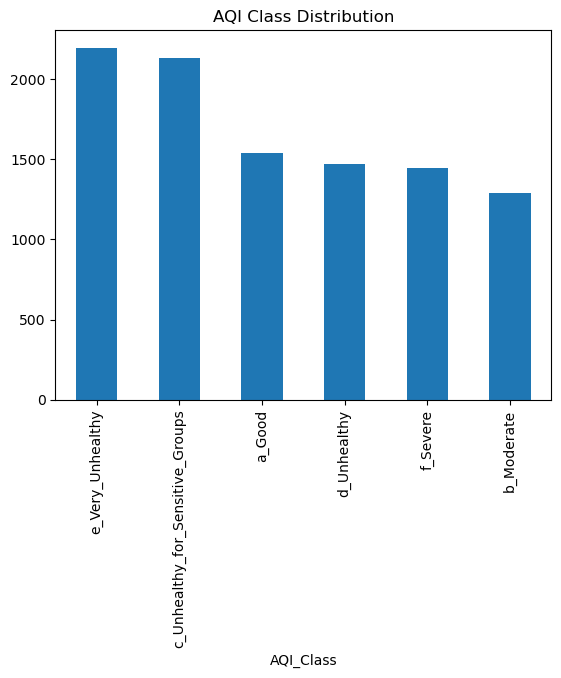

In [3]:
# 1. Basic shape
print(data.shape)

# 2. Required columns check
print(data.columns)

# 3. Check broken image paths (VERY IMPORTANT)
broken = data[~data["image_path"].apply(os.path.exists)]
print("Broken images:", len(broken))

# 4. Class distribution
print(data["AQI_Class"].value_counts())

import matplotlib.pyplot as plt
data["AQI_Class"].value_counts().plot(kind="bar", title="AQI Class Distribution")
plt.show()


In [4]:
label_encoder = LabelEncoder()
data["AQI_Class_Encoded"] = label_encoder.fit_transform(data["AQI_Class"])

NUM_CLASSES = len(label_encoder.classes_)
print("Class mapping:")
for k, v in zip(label_encoder.classes_, range(NUM_CLASSES)):
    print(f"{k} -> {v}")


Class mapping:
a_Good -> 0
b_Moderate -> 1
c_Unhealthy_for_Sensitive_Groups -> 2
d_Unhealthy -> 3
e_Very_Unhealthy -> 4
f_Severe -> 5


In [5]:
# Convert Hour column from 'HH:MM' → HH (int)
data["Hour"] = data["Hour"].astype(str).str.split(":").str[0].astype(int)
print(data["Hour"].head())
print(data["Hour"].dtype)


0    8
1    8
2    8
3    8
4    8
Name: Hour, dtype: int64
int64


In [6]:
TABULAR_FEATURES = [
    "Year", "Month", "Day", "Hour",
    "AQI",
    "PM2.5", "PM10",
    "O3", "CO", "SO2", "NO2"
]

X_tab = data[TABULAR_FEATURES]
y = data["AQI_Class_Encoded"].astype("int32")
img_paths = data["image_path"]


In [7]:
X_tab_train, X_tab_test, img_train, img_test, y_train, y_test = train_test_split(
    X_tab,
    img_paths,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [8]:
scaler = StandardScaler()
X_tab_train = scaler.fit_transform(X_tab_train)
X_tab_test = scaler.transform(X_tab_test)


In [9]:
img_train = img_train.tolist()
img_test = img_test.tolist()

y_train = y_train.values
y_test = y_test.values


In [10]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def load_image(path):
    path = tf.cast(path, tf.string)
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img

def create_dataset(img_paths, tab_data, labels, training=True):
    img_ds = tf.data.Dataset.from_tensor_slices(img_paths)
    img_ds = img_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

    tab_ds = tf.data.Dataset.from_tensor_slices(
        tf.cast(tab_data, tf.float32)
    )

    lbl_ds = tf.data.Dataset.from_tensor_slices(labels)

    ds = tf.data.Dataset.zip(((img_ds, tab_ds), lbl_ds))

    if training:
        ds = ds.shuffle(1024)

    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = create_dataset(img_train, X_tab_train, y_train, training=True)
test_ds = create_dataset(img_test, X_tab_test, y_test, training=False)


In [11]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class weights: {0: np.float64(1.0888077858880778), 1: np.float64(1.3021338506304558), 2: np.float64(0.7883147386964181), 3: np.float64(1.1425531914893616), 4: np.float64(0.7649572649572649), 5: np.float64(1.1593264248704662)}


In [12]:
# Image branch
image_input = layers.Input(shape=(224, 224, 3))
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=image_input
)

base_model.trainable = False  # first phase

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4)(x)

# Tabular branch
tab_input = layers.Input(shape=(X_tab_train.shape[1],))
t = layers.BatchNormalization()(tab_input)
t = layers.Dense(128, activation="relu")(t)
t = layers.Dropout(0.3)(t)
t = layers.Dense(64, activation="relu")(t)

# Fusion
combined = layers.concatenate([x, t])
combined = layers.Dense(256, activation="relu")(combined)
combined = layers.Dropout(0.5)(combined)

output = layers.Dense(NUM_CLASSES, activation="softmax")(combined)

model = models.Model(
    inputs=[image_input, tab_input],
    outputs=output
)


In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 224, 224, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 224, 224, 3)       │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             288 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 4,476,181 (17.08 MB)

 Trainable params: 424,028 (1.62 MB)

 Non-trainable params: 4,052,153 (15.46 MB)

In [14]:
cb = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=1e-6
    )
]


In [18]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    # class_weight=class_weights,
    callbacks=cb
)


Epoch 1/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 459s 2s/step - accuracy: 0.1723 - loss: 1.8610 - val_accuracy: 0.2105 - val_loss: 1.7883 - learning_rate: 3.0000e-06
Epoch 2/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.1837 - loss: 1.8432 - val_accuracy: 0.2085 - val_loss: 1.7867 - learning_rate: 3.0000e-06
Epoch 3/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 445s 2s/step - accuracy: 0.1847 - loss: 1.8318 - val_accuracy: 0.2105 - val_loss: 1.7869 - learning_rate: 3.0000e-06
Epoch 4/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - accuracy: 0.1841 - loss: 1.8293 - val_accuracy: 0.2140 - val_loss: 1.7863 - learning_rate: 1.0000e-06
Epoch 5/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 437s 2s/step - accuracy: 0.1921 - loss: 1.8229 - val_accuracy: 0.2145 - val_loss: 1.7858 - learning_rate: 1.0000e-06


In [16]:
# Unfreeze top layers of EfficientNet
for layer in base_model.layers[-40:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=cb
)


Epoch 1/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 449s 2s/step - accuracy: 0.1667 - loss: 1.9045 - val_accuracy: 0.2180 - val_loss: 1.7921 - learning_rate: 1.0000e-05
Epoch 2/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 401s 2s/step - accuracy: 0.1708 - loss: 1.8587 - val_accuracy: 0.1480 - val_loss: 1.7842 - learning_rate: 1.0000e-05
Epoch 3/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 409s 2s/step - accuracy: 0.1811 - loss: 1.8415 - val_accuracy: 0.1787 - val_loss: 1.7870 - learning_rate: 1.0000e-05
Epoch 4/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 407s 2s/step - accuracy: 0.1697 - loss: 1.8366 - val_accuracy: 0.1852 - val_loss: 1.7835 - learning_rate: 3.0000e-06
Epoch 5/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 410s 2s/step - accuracy: 0.1794 - loss: 1.8279 - val_accuracy: 0.2090 - val_loss: 1.7826 - learning_rate: 3.0000e-06


In [17]:
y_pred = np.argmax(model.predict(test_ds), axis=1)

print(
    classification_report(
        label_encoder.inverse_transform(y_test),
        label_encoder.inverse_transform(y_pred)
    )
)


63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step
                                  precision    recall  f1-score   support

                          a_Good       0.00      0.00      0.00       308
                      b_Moderate       0.00      0.00      0.00       258
c_Unhealthy_for_Sensitive_Groups       0.00      0.00      0.00       426
                     d_Unhealthy       0.00      0.00      0.00       294
                e_Very_Unhealthy       0.22      1.00      0.36       439
                        f_Severe       0.00      0.00      0.00       289

                        accuracy                           0.22      2014
                       macro avg       0.04      0.17      0.06      2014
                    weighted avg       0.05      0.22      0.08      2014



D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
